# Sixth Stage

### Investigate into the impact of flash orders on the simulation results

In [1]:
import sys
sys.path.append('..')
from optimization import *
from flash_order import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
target_stock_code = '0050'
side = 'bid'
ts = 20
tm = 10
max_dur = 200
trick_thres = 100

In [3]:
# First get simulation results
sim_res = read_pkl_helper(os.path.join(PROJECT_DIR, f'optres/foms=0/stock_code={target_stock_code}/side={side}/ts={ts}/tm={tm}', 'full_res.pkl'))

In [4]:
# Get flash orders
foc = FlashOrderCalculator(target_stock_code)
foc.classify(max_dur_ms=max_dur, trick_trade_thres_ms=trick_thres)

2022-12-24 11:41:06.438 | INFO     | get_data.py         :   36 | Got cache at /Users/anthonywah/Projects/mafs6100-order-placement-strategy/cache/0050.pkl - 8.14s
ClassifyingFlashOrder: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [00:13<00:00, 13.68it/s]


In [6]:
# For each simulation round, check if there is a flash order during the order placement period

for col in ['fo', 'fo_bid', 'fo_ask']:  # Record matched fo in index lists
    if col in sim_res.columns:
        sim_res = sim_res.drop(col, axis=1).reset_index(drop=True)
    sim_res.loc[:, col] = [[] for i in range(len(sim_res))]

one_fod = foc.fod[max_dur][trick_thres]
for fo in tqdm.tqdm(one_fod, desc="FindingFlashOrders", ncols=200, total=len(one_fod)):
    matched = sim_res.loc[(sim_res['start_ts'] <= fo['start_ms']) & (sim_res['fill_ts'] >= fo['end_ms'])].index
    if not len(matched):
        continue
    
    # Store case indexes
    for i in matched:
        sim_res.at[i, 'fo'].append(fo['case_index'])
    
    # Side breakdown
    if fo['side'] == 'bid':
        sim_res.at[i, 'fo_bid'].append(fo['case_index'])
    else: 
        sim_res.at[i, 'fo_ask'].append(fo['case_index'])

FindingFlashOrders: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10434/10434 [00:07<00:00, 1324.96it/s]


In [7]:
# Get simulation rounds with flash orders
sim_res_dict = {
    'Normal'.ljust(15): sim_res.copy(), 
    'With FO'.ljust(15): sim_res.loc[sim_res['fo'].apply(len) > 0, :].reset_index(drop=True), 
    'No FO'.ljust(15): sim_res.loc[sim_res['fo'].apply(len) == 0, :].reset_index(drop=True), 
    'With bid FO'.ljust(15): sim_res.loc[sim_res['fo_bid'].apply(len) > 0, :].reset_index(drop=True), 
    'No bid FO'.ljust(15): sim_res.loc[sim_res['fo_bid'].apply(len) == 0, :].reset_index(drop=True), 
    'With ask FO'.ljust(15): sim_res.loc[sim_res['fo_ask'].apply(len) > 0, :].reset_index(drop=True), 
    'No ask FO'.ljust(15): sim_res.loc[sim_res['fo_ask'].apply(len) == 0, :].reset_index(drop=True), 
}

In [8]:
# Calculation % of different fill types
log_info(f'Cases breakdown: ')
for k, i_sim_res in sim_res_dict.items():
    count_dict = i_sim_res.groupby('case')['date'].count().to_dict()
    msg = f'{k}: Count = {len(i_sim_res):>7}'
    for case in ['INIT', 'EOQREP', 'REP', 'TAKE']:
        msg += f' ; {case} = {count_dict.get(case, 0.) * 100 / len(i_sim_res):>6.2f}%'
    msg += f' ; Avg PnL = {i_sim_res["pnl"].mean():>6.3f} ; Stdev = {i_sim_res["pnl"].std():>6.3f}'
    log_info(msg)

2022-12-24 11:41:28.031 | INFO     | 652576031.py        :    2 | Cases breakdown: 
2022-12-24 11:41:28.040 | INFO     | 652576031.py        :    9 | Normal         : Count =   49945 ; INIT =   5.75% ; EOQREP =   4.69% ; REP =  28.66% ; TAKE =  60.90% ; Avg PnL = -2.085 ; Stdev =  3.115
2022-12-24 11:41:28.043 | INFO     | 652576031.py        :    9 | With FO        : Count =    4321 ; INIT =   7.94% ; EOQREP =   4.84% ; REP =  34.16% ; TAKE =  53.07% ; Avg PnL = -2.456 ; Stdev =  4.471
2022-12-24 11:41:28.051 | INFO     | 652576031.py        :    9 | No FO          : Count =   45624 ; INIT =   5.55% ; EOQREP =   4.67% ; REP =  28.13% ; TAKE =  61.65% ; Avg PnL = -2.049 ; Stdev =  2.953
2022-12-24 11:41:28.054 | INFO     | 652576031.py        :    9 | With bid FO    : Count =    1450 ; INIT =   4.41% ; EOQREP =   5.03% ; REP =  20.41% ; TAKE =  70.14% ; Avg PnL = -4.666 ; Stdev =  5.257
2022-12-24 11:41:28.062 | INFO     | 652576031.py        :    9 | No bid FO      : Count =   48495 ;

---

### Compare simulation results with consideration of flash orders

In [9]:
target_stock_code = '0050'
side = 'bid'
ts = 20
tm = 10
foms = 300

In [11]:
path_df = get_path_df()

# Limit to certain params only
path_df = path_df.loc[(files_df['ts'].astype(int) <= 20) & (files_df['tm'].astype(int) <= 20)].reset_index(drop=True)

res_dict = calc_sim_results(path_df=path_df)

In [14]:
sim_res_w_fo = read_pkl_helper(os.path.join(PROJECT_DIR, f'optres/foms={foms}/stock_code={target_stock_code}/side={side}/ts={ts}/tm={tm}', 'full_res.pkl'))
sim_res_wo_fo = read_pkl_helper(os.path.join(PROJECT_DIR, f'optres/foms=0/stock_code={target_stock_code}/side={side}/ts={ts}/tm={tm}', 'full_res.pkl'))

In [40]:
print(f'PnL mean = {sim_res_wo_fo["pnl"].mean():.2f} (W/o FO) ; {sim_res_w_fo["pnl"].mean():.2f} (W FO)') 

PnL mean = -2.08 (W/o FO) ; -2.11 (W FO)


In [34]:
print(f'Cases w fo: {len(sim_res_w_fo)} (cancelled {len(sim_res_w_fo.loc[sim_res_w_fo["case"] == "CANCEL"])}) ; Cases wo fo {len(sim_res_wo_fo)}')
w_fo_gb, wo_fo_gb = sim_res_w_fo.groupby('case'), sim_res_wo_fo.groupby('case')
for k in PLOT_CASE_LABEL.keys():
    w_fo_cnt, wo_fo_cnt = len(w_fo_gb.groups.get(k, [])), len(wo_fo_gb.groups.get(k, []))
    print(f'{k:<10} --- w fo: {w_fo_cnt:<7} ({100 * w_fo_cnt / len(sim_res_w_fo):<6.2f}%) ; wo fo: {wo_fo_cnt:<7} ({100 * wo_fo_cnt / len(sim_res_wo_fo):<6.2f}%)')

Cases w fo: 51225 (cancelled 2085) ; Cases wo fo 49945
REP        --- w fo: 12967   (25.31 %) ; wo fo: 14312   (28.66 %)
INIT       --- w fo: 2569    (5.02  %) ; wo fo: 2874    (5.75  %)
INITFFO    --- w fo: 263     (0.51  %) ; wo fo: 0       (0.00  %)
TAKE       --- w fo: 31200   (60.91 %) ; wo fo: 30418   (60.90 %)
EOQREP     --- w fo: 2141    (4.18  %) ; wo fo: 2341    (4.69  %)
CANCEL     --- w fo: 2085    (4.07  %) ; wo fo: 0       (0.00  %)


2022-12-24 11:44:26.851 | INFO     | 3614969966.py       :   15 | Plotting 0050 - bid - z_score
2022-12-24 11:44:27.291 | INFO     | 3614969966.py       :   15 | Plotting 0050 - bid - score_mean
2022-12-24 11:44:27.824 | INFO     | 3614969966.py       :   15 | Plotting 0050 - bid - score_std
2022-12-24 11:44:28.587 | INFO     | 3614969966.py       :   15 | Plotting 0050 - bid - eoq_%
2022-12-24 11:44:29.548 | INFO     | 3614969966.py       :   15 | Plotting 0050 - bid - take_%


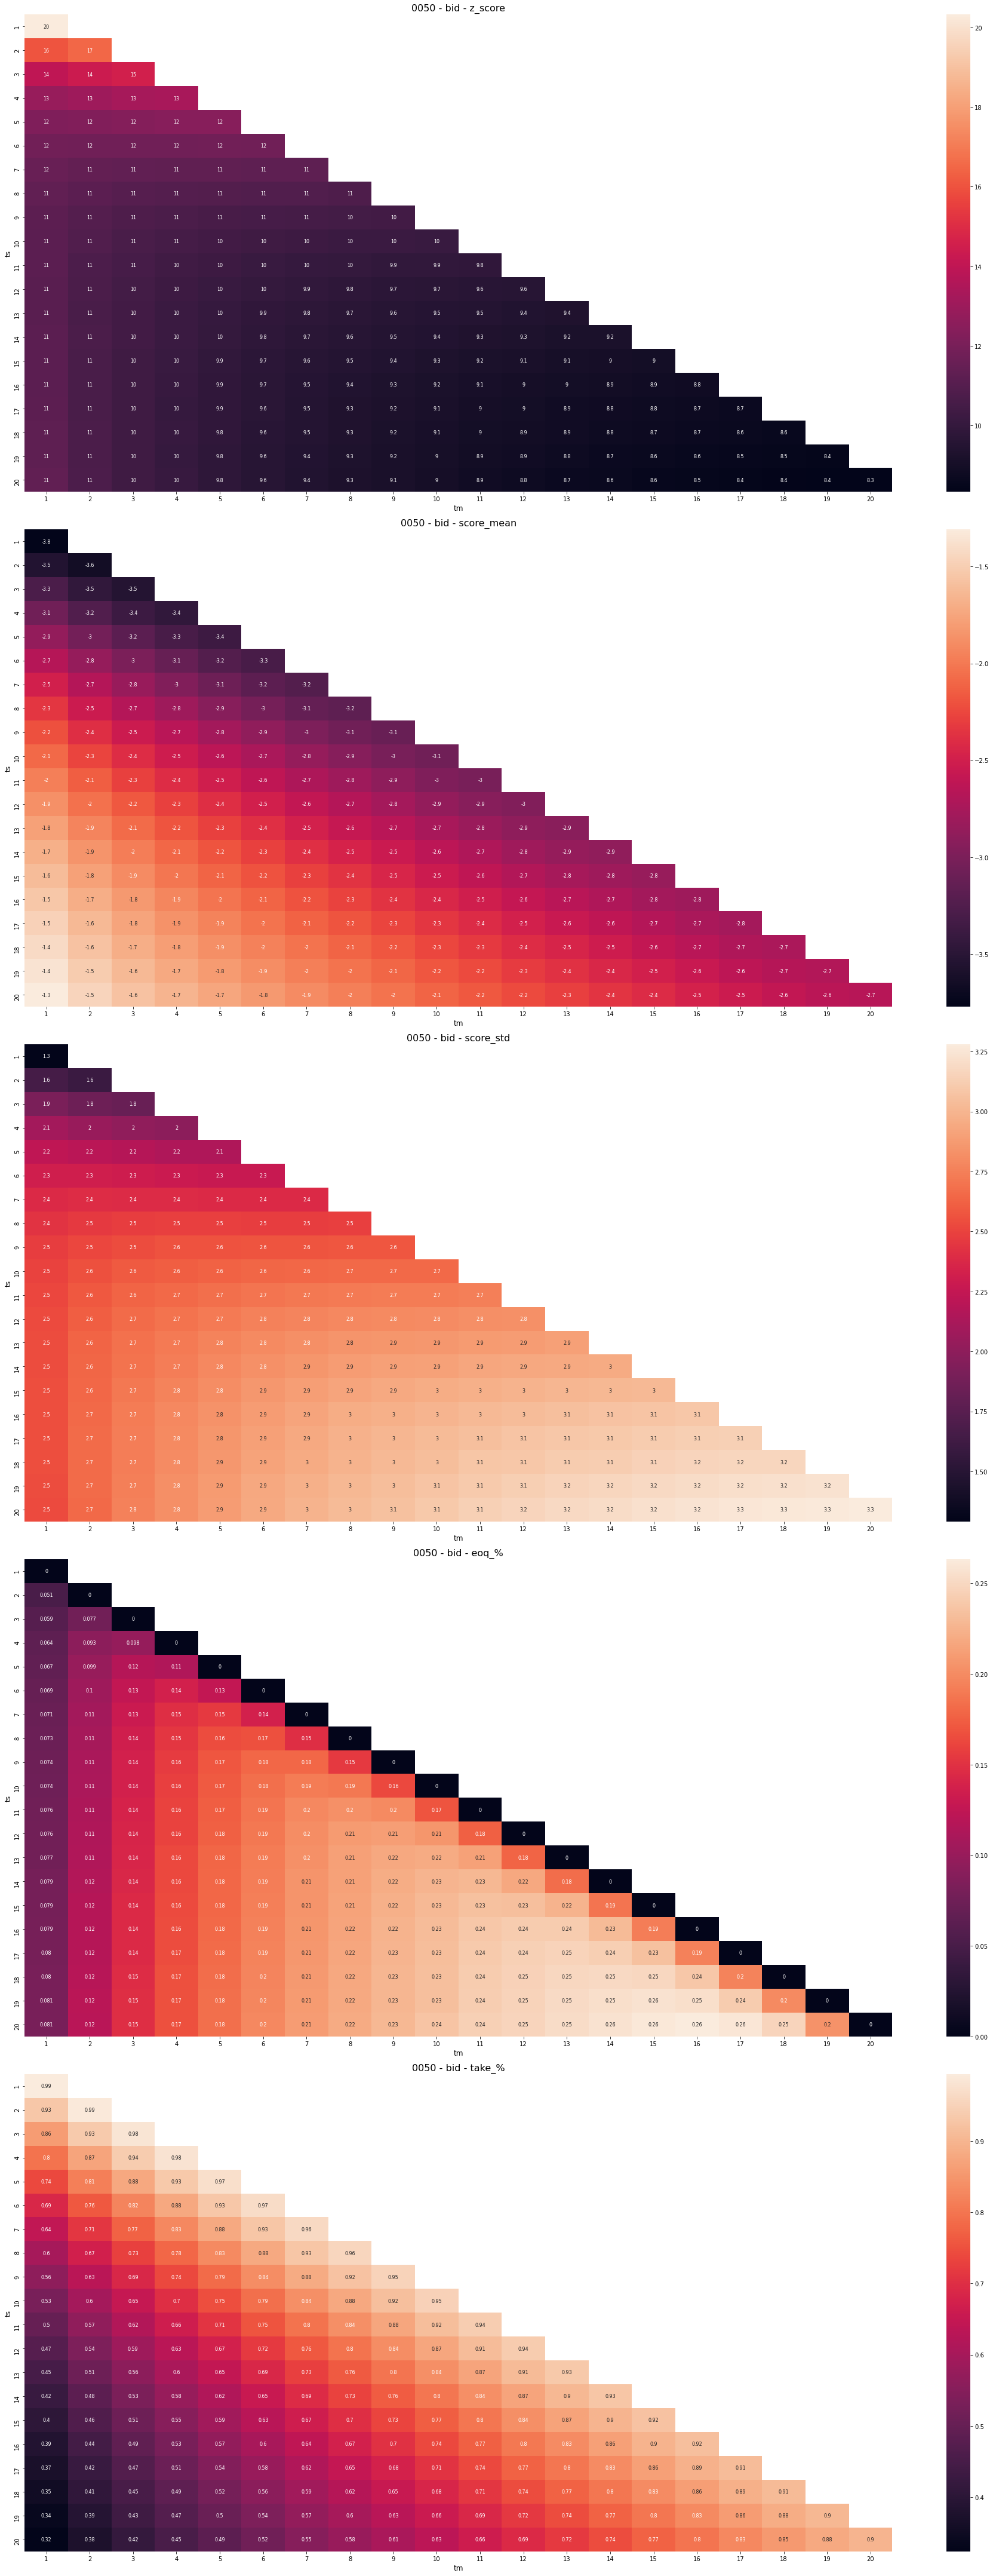

In [16]:
# foms = 300 heatmap
one_dict = {k: v for k, v in res_dict.items() if k[1] == '300'}
plot_heatmap(stock_code_ls=['0050'], side_ls=['bid'], plot_attri_ls=['z_score', 'score_mean', 'score_std', 'eoq_%', 'take_%'], res_dict=one_dict)

2022-12-24 11:44:44.413 | INFO     | 3614969966.py       :   15 | Plotting 0050 - bid - z_score
2022-12-24 11:44:44.817 | INFO     | 3614969966.py       :   15 | Plotting 0050 - bid - score_mean
2022-12-24 11:44:45.342 | INFO     | 3614969966.py       :   15 | Plotting 0050 - bid - score_std
2022-12-24 11:44:46.162 | INFO     | 3614969966.py       :   15 | Plotting 0050 - bid - eoq_%
2022-12-24 11:44:47.137 | INFO     | 3614969966.py       :   15 | Plotting 0050 - bid - take_%


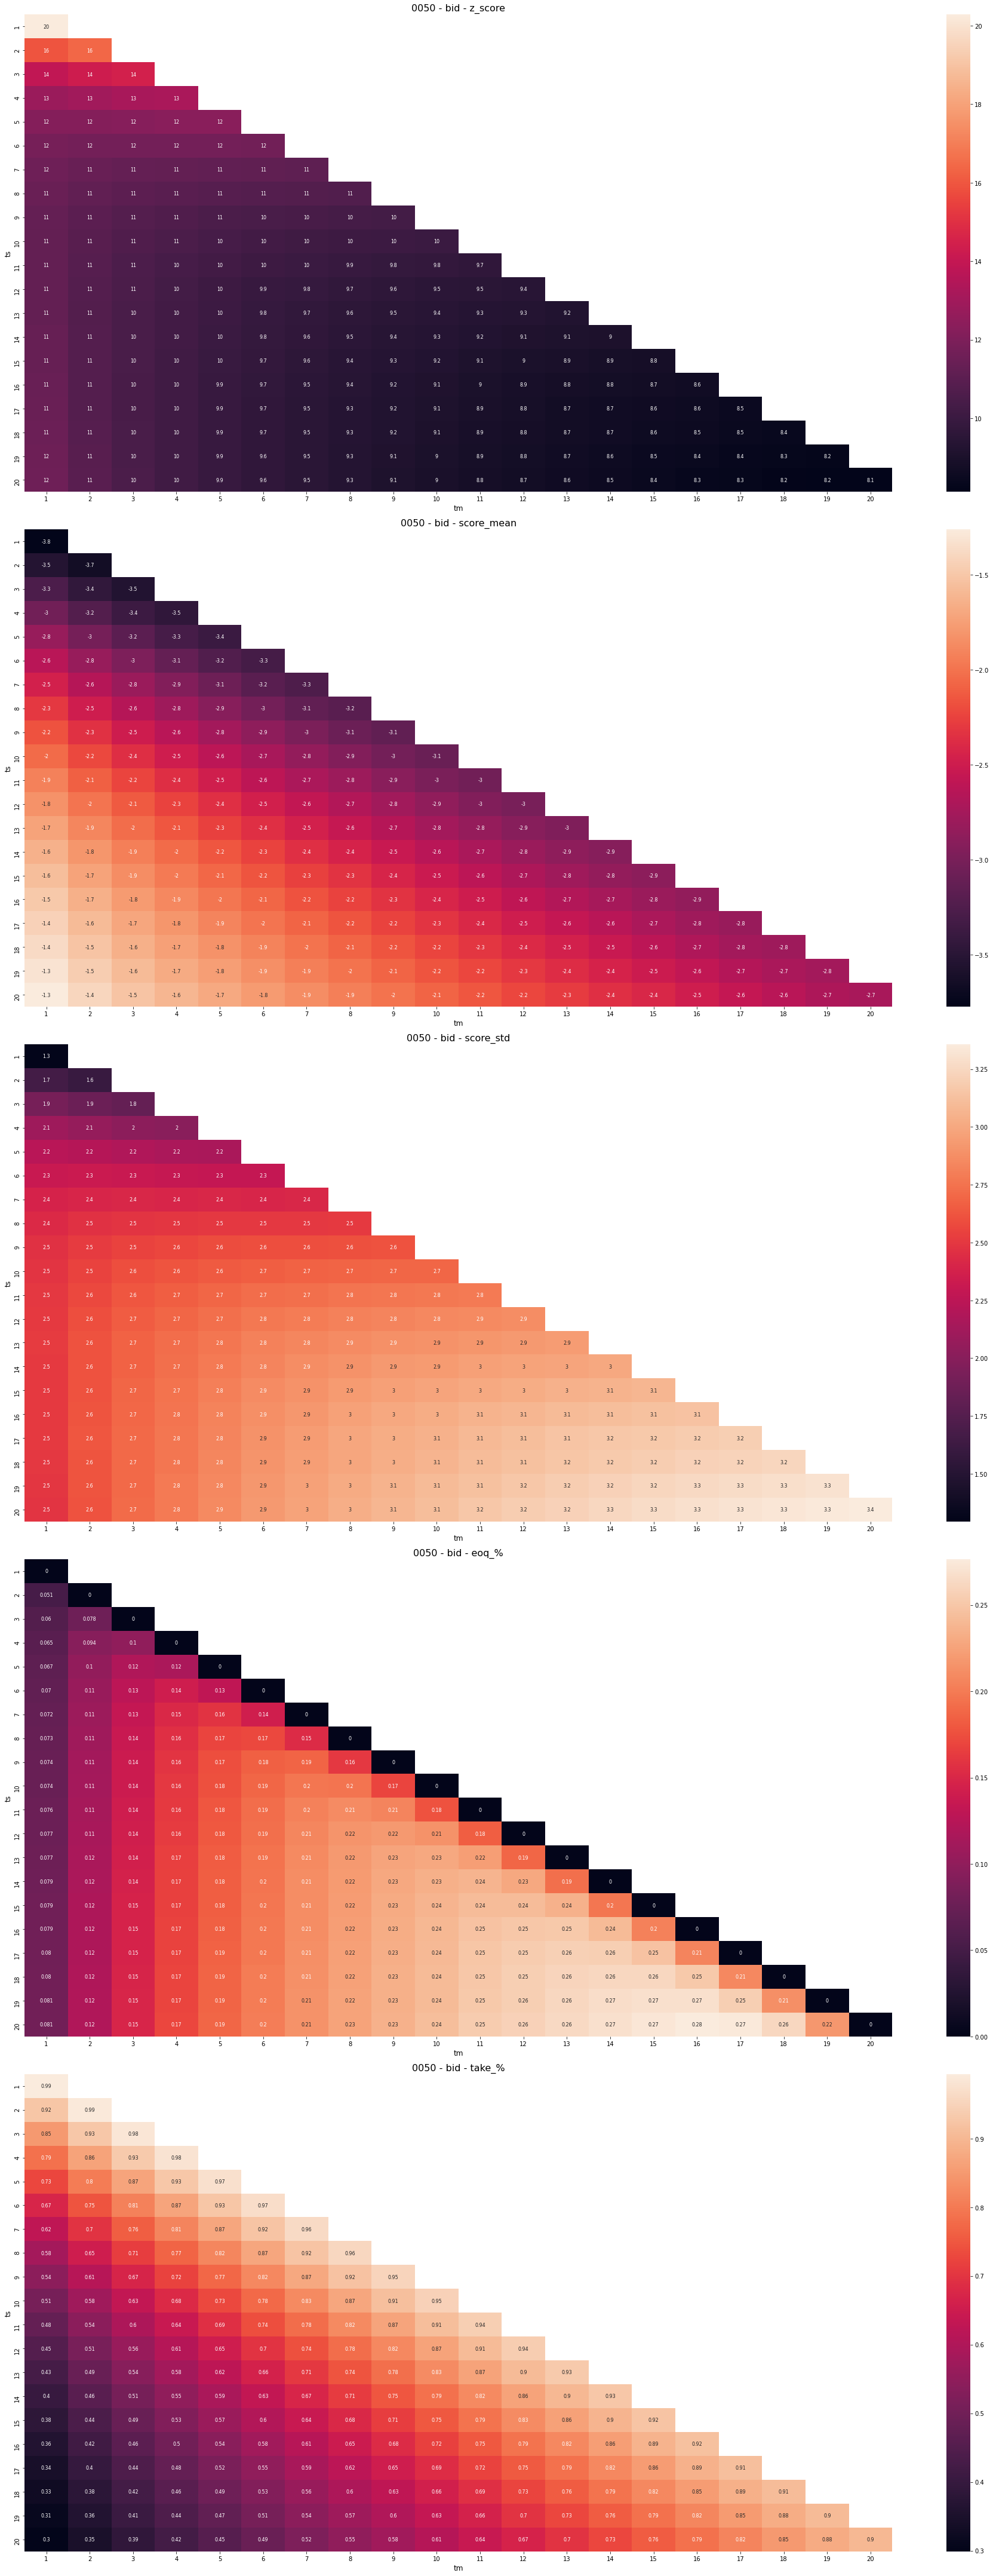

In [17]:
# foms = 0 heatmap
one_dict = {k: v for k, v in res_dict.items() if k[1] == '0'}
plot_heatmap2(stock_code_ls=['0050'], side_ls=['bid'], plot_attri_ls=['z_score', 'score_mean', 'score_std', 'eoq_%', 'take_%'], res_dict=one_dict)

---